In [14]:
import numpy as np
import random as rd
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import matplotlib.cm as cm
import scipy as SP
from PIL import Image
import threading
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [23]:
class Environment():
    
    #fields:
    #a grid of size defined by parameter
    #b, a tuple repsenting the delivery location
    #a, a tuple representing the package location
    #size, an int representing the horizontal and vertical dimensions of the grid
    def __init__(self, size:int, a = None):
        self.size = size
        self.b = (size-1, size-1)
        self.grid, self.a = self.setup_grid(size, a)
        self.reward_pickup = 100
        self.reward_deliver = 100
        self.reward_move = -1
        ## IS THIS WHERE THE AGENT SHOULD BE INITIATED?

    #method to set up the original grid including a location
    def setup_grid(self, size, a):
        grid = np.zeros((size,size))
        if a is None:
            x, y = rd.randint(0, size-1), rd.randint(0, size-1)
            while (x,y) == self.b:
                x, y = rd.randint(0, size-1), rd.randint(0, size-1)
            grid[x,y] = 1  #A represented by 1 - package
        else:
            x,y=a
            grid[x,y] = 1
        grid[size-1,size-1] = 2  #B represented by 2 - delivery destination
        return grid, (x,y)
    
    #method to add start location of agent to grid as well
 #TODO: consider whether to initialise agent as part of environment initialisation
 #pass agent coordinates into constructor instead lmao DENSE
    def set_agent_start(self, agent):
        self.agent_coords = (agent.x, agent.y)
    
    #Method which updates the location of the agent on the grid. Currently just zeroes whatever it landed on - can include other logic instead
    def move_agent(self, agent_move):
        x, y = self.agent_coords
        self.grid[x,y] = 0
        self.agent_coords = agent_move
        self.grid[agent_move] = -1
        
    def plot_grid(self):
        # Create a figure and axis with a white background
        fig, ax = plt.subplots()
        ax.set_facecolor('white')  # Set background color to white
        
        # Plot the grid
        ax.imshow(np.array([[0]]), cmap="bone", extent=[0, self.size, 0, self.size])
        
        #Load image for the agent
        agent_img = plt.imread('agent.jpg')
        agent_img = Image.open('agent.jpg')
        agent_img = agent_img.resize((100, 100))
        
        #Load image for the package - destination A
        package_img = plt.imread('package.jpg')
        package_img = Image.open('package.jpg')
        package_img = package_img.resize((100, 100))
        
        #Load image for the end destination - destination B
        destinationB_img = plt.imread('destinationB.jpg')
        destinationB_img = Image.open('destinationB.jpg')
        destinationB_img = destinationB_img.resize((100, 100))

        
        for i in range(self.size):
            for j in range(self.size):
                if (i, j) == self.agent_coords:
                    # Display agent image in the cell
                    imagebox = OffsetImage(agent_img, zoom=0.5)
                    ab = AnnotationBbox(imagebox, (j + 0.5, self.size - i - 0.5), frameon=False)
                    ax.add_artist(ab)
                elif (i,j) == self.a:
                    # Display package image in the cell
                    imagebox = OffsetImage(package_img, zoom=0.5)
                    ab = AnnotationBbox(imagebox, (j + 0.5, self.size - i - 0.5), frameon=False)
                    ax.add_artist(ab)
                elif (i,j) == self.b:
                    # Display destination image in the cell
                    imagebox = OffsetImage(destinationB_img, zoom=0.5)
                    ab = AnnotationBbox(imagebox, (j + 0.5, self.size - i - 0.5), frameon=False)
                    ax.add_artist(ab)
                else:
                    ax.text(j + 0.5, self.size - i - 0.5, self.grid[i, j], ha='center', va='center', fontsize=20, color='white')
        
        # Set axis properties
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_xticks(np.arange(self.size) + 1)
        ax.set_yticks(np.arange(self.size) + 1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True, linewidth=2, color='white')
        
        # Set title
        ax.set_title("5x5 Grid Visualization")
        
        # Show the plot
        plt.show()

#An agent class. Currently barebones
class Agent():
    def __init__(self, environ):
        self.environ = environ
        self.reset_agent()
        self.opts = ["up", "down", "left", "right"]
        

    # choose the best action based on the greedy policy on Q-values
    # filed qmat = Q-matrix of size n*n*options where n=grid_size, options=actions
    def choose_best_option(self, qmat):
        state_qs = qmat[self.x,self.y] # 1*1*options
        action = np.argmax(state_qs) # choose action based on greedy policy where 0=up, 1=down, 2=left, 3=right
        return action

    #Ensure that moves
    def move(self, direction):

        if direction=="up":
            if self.x-1 >= 0:
                self.x = self.x-1
        if direction=="down":
            if self.x+1 < self.environ.size:
                self.x = self.x+1
        if direction=="left":
            if self.y-1 >= 0:
                self.y = self.y-1
        if direction=="right":
            if self.y+1 < self.environ.size:
                self.y=self.y+1
        
        if self.collected == 0:
            if (self.x, self.y) == self.environ.a:
                self.collected = 1
                reward = self.environ.reward_pickup
            else:
                reward = self.environ.reward_move
        
        else:
            if (self.x, self.y) == self.environ.b:
                self.end_episode = 1
                reward = self.environ.reward_deliver
            else:
                reward = self.environ.reward_move

        return (self.x, self.y), reward, self.end_episode
    
    def reset_agent(self):
        self.x, self.y = rd.randint(0, self.environ.size-1), rd.randint(0, self.environ.size-1)
        while ((self.x, self.y) == (self.environ.a or self.environ.b)):
            self.x, self.y = rd.randint(0, self.environ.size-1), rd.randint(0, self.environ.size-1)
        self.collected = 0
        self.end_episode = 0
    
#Class to store hyperparameters
class Hypers():
    def __init__(self, eps, gamma, alpha, steps_per_ep, total_iter):
        self.eps = eps
        self.gamma = gamma
        self.alpha = alpha
        self.steps_per_ep = steps_per_ep
        self.total_iter = total_iter

##Method to initiate agent coordinates should go in setup method since both the Environment and the Agent need to know
#Or we need a hierarchy - consult w/ group

## Q Learn Notes

Rewards come from the environment, agent has values on states that it figures out from the rewards that the environment offers it.

Game has multiple episodes (like, tens of thousands).

Episode has multiple (hundreds?) timesteps. At each episode, we'll have a different location of A from all 24 possible states.

Q table learned across all 24 A locations, 25 agent locations, 4 possible actions, and the pre/post plant situation.

So in total 24 * 25 * 2 states, and four possible actions in each state.

4800 state-action space in total for this toy example.

#### SPECULATIVELY;

If we're constructing this Q-table and using the Bellman equation to backpropagate the rewards from end-state into the Q table, we are effectively "learning" a table which tells us what future rewards are going to be in future states. This lets us, in our _current_ state, choose the action which will best be producing future rewards. So our first near empty Q table will have the agent wander around effectively randomly.


Start with a fixed A and fixed B, to see if you CAN actually learn the Q values. Only THEN do we change to a dynamic location of A.

In [27]:
# Demo

hypers = Hypers(
    eps = 0.1, 
    gamma = 0.9,
    alpha = 0.01,
    steps_per_ep = 100,
    total_iter = 10000
)

import random as rd

env = Environment(size = 5, a=(2,3))
bond = Agent(env)
env.set_agent_start(bond)



qmat = np.zeros([env.size,env.size,len(bond.opts)])

for i in range(hypers.total_iter):
    print("qmat = ", np.argmax(qmat,2))
    
    bond.reset_agent()
    print("pickup - a: ",env.a)
    print("agent - pos: ",bond.x,bond.y)
    
    for s in range(hypers.steps_per_ep):

        # choose between explore and exploit (epsilon-greedy)
        if rd.random()<hypers.eps:
            action = rd.randint(0,len(bond.opts)-1)
        else:
            action = bond.choose_best_option(qmat)

        
        state = [bond.x, bond.y]

        next_state, reward, end_episode = bond.move(bond.opts[action])
        env.move_agent(next_state)
        next_action = np.argmax(qmat[next_state[0],next_state[1]])

        qmat[state[0],state[1],action]+=hypers.alpha*(reward + (hypers.gamma*(qmat[next_state[0],next_state[1],next_action])) - qmat[state[0],state[1],action])

        print("s, reward: ", s, reward)
        if end_episode == 1:
            print("qmat = ", np.argmax(qmat,2))
            print("end of episode")
            break


# for i in range(10):
#     env.move_agent(bond.move(rd.choice(bond.opts)))
#     print(env.grid)
#     env.plot_grid()
#     time.sleep(1)


# class QL():
#     def __init__(self, environ, agent):

qmat =  [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
pickup - a:  (2, 3)
agent - pos:  1 3
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 -1
s, reward:  10 -1
s, reward:  11 100
s, reward:  12 -1
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 -1
s, reward:  20 -1
s, reward:  21 -1
s, reward:  22 -1
s, reward:  23 -1
s, reward:  24 -1
s, reward:  25 -1
s, reward:  26 -1
s, reward:  27 -1
s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 -1
s, reward:  31 -1
s, reward:  32 -1
s, reward:  33 -1
s, reward:  34 -1
s, reward:  35 -1
s, reward:  36 -1
s, reward:  37 -1
s, reward:  38 -1
s, reward:  39 -1
s, reward:  40 -1
s, reward:  41 -1
s, reward:  42 -1
s, reward:  43 -1
s, reward:  44 -1
s, reward:  45 -1
s, reward:  46 -1
s, reward:  47 -1
s, reward:  48 -1
s, reward:  49 

s, reward:  56 -1
s, reward:  57 -1
s, reward:  58 -1
s, reward:  59 -1
s, reward:  60 -1
s, reward:  61 -1
s, reward:  62 -1
s, reward:  63 -1
s, reward:  64 -1
s, reward:  65 -1
s, reward:  66 -1
s, reward:  67 -1
s, reward:  68 -1
s, reward:  69 -1
s, reward:  70 -1
s, reward:  71 -1
s, reward:  72 -1
s, reward:  73 -1
s, reward:  74 -1
s, reward:  75 -1
s, reward:  76 -1
s, reward:  77 -1
s, reward:  78 -1
s, reward:  79 -1
s, reward:  80 -1
s, reward:  81 -1
s, reward:  82 -1
s, reward:  83 -1
s, reward:  84 -1
s, reward:  85 -1
s, reward:  86 -1
s, reward:  87 -1
s, reward:  88 -1
s, reward:  89 -1
s, reward:  90 -1
s, reward:  91 -1
s, reward:  92 -1
s, reward:  93 -1
s, reward:  94 -1
s, reward:  95 -1
s, reward:  96 -1
s, reward:  97 -1
s, reward:  98 -1
s, reward:  99 -1
qmat =  [[3 3 1 1 1]
 [2 3 3 1 1]
 [3 3 3 0 2]
 [2 0 0 3 1]
 [0 1 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  1 4
s, reward:  0 -1
s, reward:  1 100
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:

s, reward:  11 -1
s, reward:  12 -1
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 -1
s, reward:  20 -1
s, reward:  21 -1
s, reward:  22 -1
s, reward:  23 -1
s, reward:  24 -1
s, reward:  25 -1
s, reward:  26 -1
s, reward:  27 -1
s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 -1
s, reward:  31 -1
s, reward:  32 -1
s, reward:  33 -1
s, reward:  34 -1
s, reward:  35 -1
s, reward:  36 -1
s, reward:  37 -1
s, reward:  38 -1
s, reward:  39 -1
s, reward:  40 -1
s, reward:  41 -1
s, reward:  42 -1
s, reward:  43 -1
s, reward:  44 -1
s, reward:  45 -1
s, reward:  46 -1
s, reward:  47 -1
s, reward:  48 -1
s, reward:  49 -1
s, reward:  50 -1
s, reward:  51 -1
s, reward:  52 -1
s, reward:  53 -1
s, reward:  54 -1
s, reward:  55 -1
s, reward:  56 -1
s, reward:  57 -1
s, reward:  58 -1
s, reward:  59 -1
s, reward:  60 -1
s, reward:  61 -1
s, reward:  62 -1
s, reward:  63 -1
s, reward:  64 -1
s, reward:  65 -1
s, reward:

s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 100
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  4 3
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 -1
s, reward:  10 -1
s, reward:  11 -1
s, reward:  12 -1
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 -1
s, reward:  20 -1
s, reward:  21 -1
s, reward:  22 -1
s, reward:  23 -1
s, reward:  24 -1
s, reward:  25 -1
s, reward:  26 -1
s, reward:  27 -1
s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 -1
s, reward:  31 -1
s, reward:  32 -1
s, reward:  33 -1
s, reward:  34 -1
s, reward:  35 -1
s, reward:  36 -1
s, reward:  37 -1
s, reward:  38 -1
s, 

s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 -1
s, reward:  10 -1
s, reward:  11 -1
s, reward:  12 -1
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 100
s, reward:  20 -1
s, reward:  21 -1
s, reward:  22 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  4 4
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 -1
s, reward:  10 -1
s, reward:  11 -1
s, reward:  12 -1
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 -1
s, reward:  20 -1
s, reward:  21 -1
s, reward:  22 -1
s, rew

s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 -1
s, reward:  31 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 2 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 2 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  4 0
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 -1
s, reward:  10 -1
s, reward:  11 -1
s, reward:  12 -1
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 -1
s, reward:  20 -1
s, reward:  21 -1
s, reward:  22 -1
s, reward:  23 -1
s, reward:  24 -1
s, reward:  25 -1
s, reward:  26 -1
s, reward:  27 -1
s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 -1
s, reward:  31 -1
s, reward:  32 -1
s, reward:  33 -1
s, reward:  34 -1
s, reward:  35 -1
s, reward:  36 -1
s, reward:  37 -1
s, reward:  38 -1
s, reward:  39 -1
s, reward:  40 -

s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 100
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 0 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 0 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  2 4
s, reward:  0 100
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 0 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 0 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  2 0
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 100
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 2 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 2 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  1 4


s, reward:  69 -1
s, reward:  70 -1
s, reward:  71 -1
s, reward:  72 -1
s, reward:  73 -1
s, reward:  74 -1
s, reward:  75 -1
s, reward:  76 -1
s, reward:  77 -1
s, reward:  78 -1
s, reward:  79 -1
s, reward:  80 -1
s, reward:  81 -1
s, reward:  82 100
s, reward:  83 -1
s, reward:  84 -1
s, reward:  85 -1
s, reward:  86 -1
s, reward:  87 -1
s, reward:  88 -1
s, reward:  89 -1
s, reward:  90 -1
s, reward:  91 -1
s, reward:  92 -1
s, reward:  93 -1
s, reward:  94 -1
s, reward:  95 -1
s, reward:  96 -1
s, reward:  97 -1
s, reward:  98 -1
s, reward:  99 -1
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 3 2]
 [0 0 0 3 0]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  2 0
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 100
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 -1
s, reward:  10 -1
s, reward:  11 -1
s, reward:  12 -1
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18

s, reward:  26 -1
s, reward:  27 -1
s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 -1
s, reward:  31 -1
s, reward:  32 -1
s, reward:  33 -1
s, reward:  34 -1
s, reward:  35 -1
s, reward:  36 -1
s, reward:  37 -1
s, reward:  38 -1
s, reward:  39 -1
s, reward:  40 -1
s, reward:  41 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 3 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 3 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  2 1
s, reward:  0 -1
s, reward:  1 100
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 -1
s, reward:  10 -1
s, reward:  11 -1
s, reward:  12 -1
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 -1
s, reward:  20 -1
s, reward:  21 -1
s, reward:  22 -1
s, reward:  23 -1
s, reward:  24 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 2 2]
 [0 0 0 3 1]
 [3 3 3 

s, reward:  24 -1
s, reward:  25 -1
s, reward:  26 -1
s, reward:  27 -1
s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 -1
s, reward:  31 -1
s, reward:  32 -1
s, reward:  33 -1
s, reward:  34 -1
s, reward:  35 -1
s, reward:  36 -1
s, reward:  37 -1
s, reward:  38 -1
s, reward:  39 -1
s, reward:  40 -1
s, reward:  41 -1
s, reward:  42 -1
s, reward:  43 -1
s, reward:  44 -1
s, reward:  45 -1
s, reward:  46 -1
s, reward:  47 -1
s, reward:  48 -1
s, reward:  49 -1
s, reward:  50 -1
s, reward:  51 -1
s, reward:  52 -1
s, reward:  53 -1
s, reward:  54 100
s, reward:  55 -1
s, reward:  56 -1
s, reward:  57 -1
s, reward:  58 -1
s, reward:  59 -1
s, reward:  60 -1
s, reward:  61 -1
s, reward:  62 -1
s, reward:  63 -1
s, reward:  64 -1
s, reward:  65 -1
s, reward:  66 -1
s, reward:  67 -1
s, reward:  68 -1
s, reward:  69 -1
s, reward:  70 -1
s, reward:  71 -1
s, reward:  72 -1
s, reward:  73 -1
s, reward:  74 -1
s, reward:  75 -1
s, reward:  76 -1
s, reward:  77 -1
s, reward:  78 -1
s, reward

s, reward:  4 100
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 2 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 2 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  3 1
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 100
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  1 3
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 100
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 0 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 0 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  1 2
s, reward:  0 -1
s, reward:  1 100
s, reward:  2 -1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



s, reward:  1 100
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  0 0
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 100
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  4 2
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 -1
s, reward:  10 -1
s, reward:  11 -1
s, reward:  12 100
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]


s, reward:  49 -1
s, reward:  50 -1
s, reward:  51 -1
s, reward:  52 -1
s, reward:  53 -1
s, reward:  54 -1
s, reward:  55 -1
s, reward:  56 -1
s, reward:  57 -1
s, reward:  58 -1
s, reward:  59 -1
s, reward:  60 -1
s, reward:  61 -1
s, reward:  62 -1
s, reward:  63 -1
s, reward:  64 -1
s, reward:  65 -1
s, reward:  66 -1
s, reward:  67 -1
s, reward:  68 -1
s, reward:  69 -1
s, reward:  70 -1
s, reward:  71 -1
s, reward:  72 -1
s, reward:  73 -1
s, reward:  74 -1
s, reward:  75 -1
s, reward:  76 -1
s, reward:  77 -1
s, reward:  78 -1
s, reward:  79 -1
s, reward:  80 -1
s, reward:  81 -1
s, reward:  82 -1
s, reward:  83 -1
s, reward:  84 -1
s, reward:  85 -1
s, reward:  86 -1
s, reward:  87 -1
s, reward:  88 -1
s, reward:  89 -1
s, reward:  90 -1
s, reward:  91 -1
s, reward:  92 -1
s, reward:  93 -1
s, reward:  94 -1
s, reward:  95 -1
s, reward:  96 -1
s, reward:  97 -1
s, reward:  98 -1
s, reward:  99 -1
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 0 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup -

s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 -1
s, reward:  20 -1
s, reward:  21 -1
s, reward:  22 -1
s, reward:  23 -1
s, reward:  24 -1
s, reward:  25 -1
s, reward:  26 -1
s, reward:  27 -1
s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 -1
s, reward:  31 -1
s, reward:  32 -1
s, reward:  33 -1
s, reward:  34 -1
s, reward:  35 -1
s, reward:  36 -1
s, reward:  37 -1
s, reward:  38 -1
s, reward:  39 -1
s, reward:  40 -1
s, reward:  41 -1
s, reward:  42 -1
s, reward:  43 -1
s, reward:  44 -1
s, reward:  45 -1
s, reward:  46 -1
s, reward:  47 -1
s, reward:  48 -1
s, reward:  49 -1
s, reward:  50 -1
s, reward:  51 -1
s, reward:  52 -1
s, reward:  53 -1
s, reward:  54 -1
s, reward:  55 -1
s, reward:  56 -1
s, reward:  57 -1
s, reward:  58 -1
s, reward:  59 -1
s, reward:  60 -1
s, reward:  61 -1
s, reward:  62 -1
s, reward:  63 -1
s, reward:  64 -1
s, reward:  65 -1
s, reward:  66 -1
s, reward:  67 -1
s, reward:  68 -1
s, reward:  69 -1
s, reward:  70 -1
s, reward:  71 -1
s, reward:

s, reward:  38 -1
s, reward:  39 -1
s, reward:  40 -1
s, reward:  41 -1
s, reward:  42 -1
s, reward:  43 -1
s, reward:  44 -1
s, reward:  45 -1
s, reward:  46 -1
s, reward:  47 -1
s, reward:  48 -1
s, reward:  49 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 3 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 3 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  0 3
s, reward:  0 -1
s, reward:  1 100
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 3 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 3 2]
 [0 0 0 3 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  3 3
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 100
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 -1
s, reward:  10 -1
s, reward:  11 -1
s, reward:  12 -1
s

s, reward:  22 -1
s, reward:  23 -1
s, reward:  24 -1
s, reward:  25 -1
s, reward:  26 -1
s, reward:  27 -1
s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 -1
s, reward:  31 -1
s, reward:  32 -1
s, reward:  33 -1
s, reward:  34 -1
s, reward:  35 -1
s, reward:  36 -1
s, reward:  37 -1
s, reward:  38 -1
s, reward:  39 -1
s, reward:  40 -1
s, reward:  41 -1
s, reward:  42 -1
s, reward:  43 -1
s, reward:  44 -1
s, reward:  45 -1
s, reward:  46 -1
s, reward:  47 -1
s, reward:  48 -1
s, reward:  49 -1
s, reward:  50 -1
s, reward:  51 -1
s, reward:  52 -1
s, reward:  53 -1
s, reward:  54 -1
s, reward:  55 -1
s, reward:  56 -1
s, reward:  57 -1
s, reward:  58 -1
s, reward:  59 -1
s, reward:  60 -1
s, reward:  61 -1
s, reward:  62 -1
s, reward:  63 -1
s, reward:  64 -1
s, reward:  65 -1
s, reward:  66 -1
s, reward:  67 -1
s, reward:  68 -1
s, reward:  69 -1
s, reward:  70 -1
s, reward:  71 -1
s, reward:  72 -1
s, reward:  73 -1
s, reward:  74 -1
s, reward:  75 -1
s, reward:  76 -1
s, reward:

s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 -1
s, reward:  20 -1
s, reward:  21 -1
s, reward:  22 -1
s, reward:  23 -1
s, reward:  24 -1
s, reward:  25 -1
s, reward:  26 -1
s, reward:  27 -1
s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 -1
s, reward:  31 -1
s, reward:  32 -1
s, reward:  33 -1
s, reward:  34 -1
s, reward:  35 -1
s, reward:  36 -1
s, reward:  37 -1
s, reward:  38 -1
s, reward:  39 -1
s, reward:  40 -1
s, reward:  41 -1
s, reward:  42 -1
s, reward:  43 -1
s, reward:  44 -1
s, reward:  45 -1
s, reward:  46 -1
s, reward:  47 -1
s, reward:  48 -1
s, reward:  49 -1
s, reward:  50 -1
s, reward:  51 -1
s, reward:  52 -1
s, reward:  53 -1
s, reward:  54 -1
s, reward:  55 -1
s, reward:  56 -1
s, reward:  57 -1
s, reward:  58 -1
s, reward:  59 -1
s, reward:  60 -1
s, reward:  61 -1
s, reward:  62 -1
s, reward:  63 -1
s, reward:  64 -1
s, reward:  65 -1
s, reward:  66 -1
s, reward:  67 -1
s, reward:  68 -1
s, reward:

s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 -1
s, reward:  10 -1
s, reward:  11 -1
s, reward:  12 -1
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 -1
s, reward:  20 -1
s, reward:  21 -1
s, reward:  22 -1
s, reward:  23 -1
s, reward:  24 -1
s, reward:  25 -1
s, reward:  26 -1
s, reward:  27 -1
s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 2 2]
 [0 0 0 0 1]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 2 2]
 [0 0 0 0 1]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  4 1
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 -1
s, reward:  10 -1
s, reward:  11 -1
s, reward:  12 -1
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 -1
s,

s, reward:  30 -1
s, reward:  31 -1
s, reward:  32 -1
s, reward:  33 -1
s, reward:  34 -1
s, reward:  35 -1
s, reward:  36 -1
s, reward:  37 -1
s, reward:  38 -1
s, reward:  39 -1
s, reward:  40 -1
s, reward:  41 -1
s, reward:  42 -1
s, reward:  43 -1
s, reward:  44 -1
s, reward:  45 -1
s, reward:  46 -1
s, reward:  47 -1
s, reward:  48 -1
s, reward:  49 -1
s, reward:  50 -1
s, reward:  51 -1
s, reward:  52 -1
s, reward:  53 -1
s, reward:  54 -1
s, reward:  55 -1
s, reward:  56 -1
s, reward:  57 -1
s, reward:  58 -1
s, reward:  59 -1
s, reward:  60 -1
s, reward:  61 -1
s, reward:  62 -1
s, reward:  63 -1
s, reward:  64 -1
s, reward:  65 -1
s, reward:  66 -1
s, reward:  67 -1
s, reward:  68 -1
s, reward:  69 -1
s, reward:  70 -1
s, reward:  71 -1
s, reward:  72 -1
s, reward:  73 -1
s, reward:  74 -1
s, reward:  75 -1
s, reward:  76 -1
s, reward:  77 -1
s, reward:  78 -1
s, reward:  79 -1
s, reward:  80 -1
s, reward:  81 -1
s, reward:  82 -1
s, reward:  83 -1
s, reward:  84 -1
s, reward:

s, reward:  12 -1
s, reward:  13 -1
s, reward:  14 -1
s, reward:  15 -1
s, reward:  16 -1
s, reward:  17 -1
s, reward:  18 -1
s, reward:  19 -1
s, reward:  20 -1
s, reward:  21 -1
s, reward:  22 -1
s, reward:  23 -1
s, reward:  24 -1
s, reward:  25 -1
s, reward:  26 -1
s, reward:  27 -1
s, reward:  28 -1
s, reward:  29 -1
s, reward:  30 -1
s, reward:  31 -1
s, reward:  32 -1
s, reward:  33 -1
s, reward:  34 -1
s, reward:  35 -1
s, reward:  36 -1
s, reward:  37 -1
s, reward:  38 -1
s, reward:  39 -1
s, reward:  40 -1
s, reward:  41 -1
s, reward:  42 -1
s, reward:  43 -1
s, reward:  44 -1
s, reward:  45 -1
s, reward:  46 -1
s, reward:  47 -1
s, reward:  48 -1
s, reward:  49 -1
s, reward:  50 -1
s, reward:  51 -1
s, reward:  52 -1
s, reward:  53 -1
s, reward:  54 -1
s, reward:  55 -1
s, reward:  56 -1
s, reward:  57 -1
s, reward:  58 -1
s, reward:  59 -1
s, reward:  60 100
s, reward:  61 -1
s, reward:  62 -1
s, reward:  63 -1
s, reward:  64 -1
s, reward:  65 -1
s, reward:  66 -1
s, reward

s, reward:  5 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 2]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 2]]
pickup - a:  (2, 3)
agent - pos:  2 1
s, reward:  0 -1
s, reward:  1 100
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 2]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 2]]
pickup - a:  (2, 3)
agent - pos:  1 3
s, reward:  0 100
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 2]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 2]]
pickup - a:  (2, 3)
agent - pos:  3 0
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 100
s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3

s, reward:  6 -1
s, reward:  7 -1
s, reward:  8 -1
s, reward:  9 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  2 0
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 100
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  0 4
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 100
s, reward:  4 -1
s, reward:  5 -1
s, reward:  6 100
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 0]]
end of episode
qmat =  [[3 1 1 1 1]
 [3 3 3 1 1]
 [3 3 3 1 2]
 [0 0 0 1 0]
 [3 3 3 3 0]]
pickup - a:  (2, 3)
agent - pos:  1 0
s, reward:  0 -1
s, reward:  1 -1
s, reward:  2 -1
s, reward:  3 -1
s, reward:  4 -1
s, reward:  5 100


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



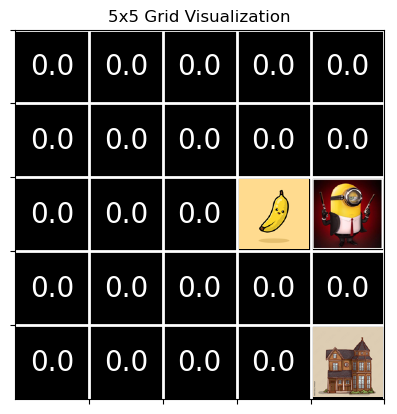

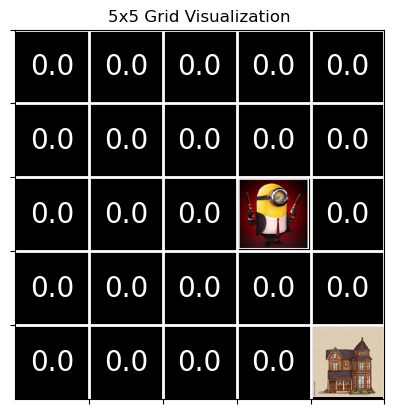

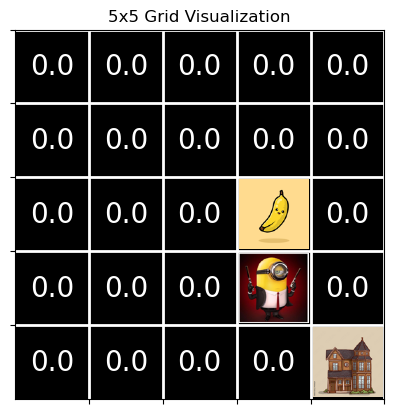

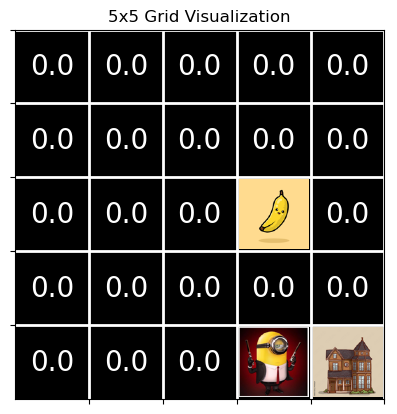

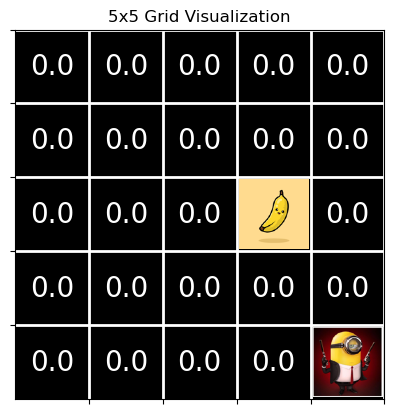

In [26]:
env = Environment(size = 5,a=(2,3))
bond = Agent(env)
env.set_agent_start(bond)

for step in range(10):
    state = [bond.x, bond.y]
    action = np.argmax(qmat[state[0],state[1]])
    pos,_,end = bond.move(bond.opts[action])
    env.move_agent(pos) 
    # print(env.grid)
    env.plot_grid()
    if end == 1:
        break